# Tema d'esame 03-02-2023


In [186]:
import numpy as np
import scipy.stats as sc
from scipy.stats import norm
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/gio/Desktop/LaboratorioCalcoloEStatistica/")
from mylib.basics import sturges
from mylib.matstyle import hist_style
from mylib.integrals import crude_montecarlo

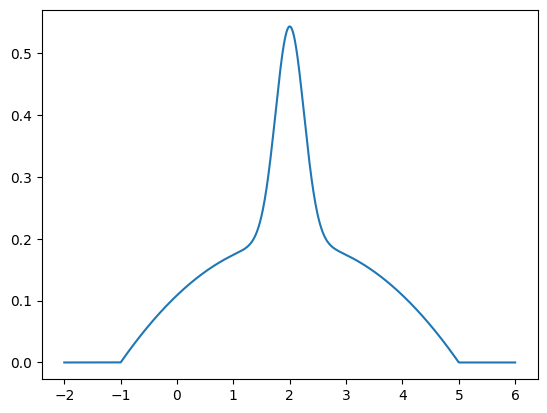

In [187]:
def theta(x,a,b):
    if type(x) == np.ndarray or type(x) == list:
        return np.array([1 if a <= i and b>= i else 0 for i in x])
    else: return 1 if a <= x and b>= x else 0

def parabola(x,a,b,c):
    return a*x**2 + b*x + c

area_para = crude_montecarlo(lambda x: -0.2*x**2+0.8*x+1,-1,5)[0]
area_gauss = crude_montecarlo(lambda x: 2*norm.pdf(x,loc=2,scale=0.25),-1,5)[0]
# area_tot = crude_montecarlo(lambda x: 2*norm.pdf(x,loc=2,scale=0.25),-1,5)[0]
area_tot = area_para + area_gauss

scale_para = area_para/area_tot
scale_gauss = area_gauss/area_tot

# PDF
pdf_parabola = lambda x: parabola(x,-0.2,0.8,1)/area_para #* theta(x,-1,5) # normalized
pdf_gauss = lambda x: norm.pdf(x,loc=2,scale=0.25) #* theta(x,-1,5)

def pdf(x):
    val = scale_para*pdf_parabola(x) + scale_gauss*pdf_gauss(x)
    if type(val) == np.ndarray:
        return np.array([i if i>0 else 0 for i in val])
    return val if val>=0 else 0

# print(crude_montecarlo(pdf,-1,5)[0])

X = np.linspace(-2,6,1000)
plt.plot(X,pdf(X))
plt.show()

In [188]:
def rand_uniform(min,max,size=1):
    if size==1: return np.float64(np.random.rand()*(max-min) + min)
    return np.random.rand(size)*(max-min) + min

def rand_TAC(pdf,xmin,xmax,ymax,size=1):
    l = np.empty(size,dtype=np.float64)
    for i in range(size):
        randX = rand_uniform(xmin,xmax,size=1)
        while pdf(randX) < rand_uniform(0,ymax,size=1):
            randX = rand_uniform(xmin,xmax,size=1)
        l[i] = randX
    return l[0] if size == 1 else l

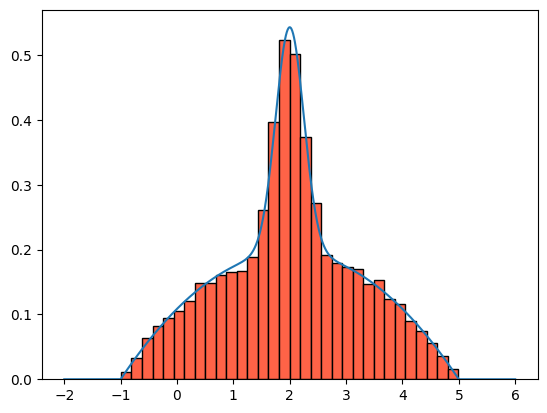

In [198]:
N = 10000
data = rand_TAC(pdf,-1,5,1,size=N)
plt.hist(data, bins = sturges(N), edgecolor='black', color='tomato',density=True) #,**hist_style(len(data))
plt.plot(X,pdf(X))
plt.show()

# __Parameters estimation:__

In [195]:
from iminuit.cost import ExtendedBinnedNLL
from iminuit import Minuit

bin_edges = np.linspace(np.min(data),np.max(data),sturges(N))
bin_content = np.array([len(data[(data>i)*(data<=g)]) for i,g in zip(bin_edges[:-1],bin_edges[1:])])
bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])

In [196]:
def g_total(x, N_background, a, b, c, N_signal, n, mu, sigma):
    return  N_background * (a * x**3 * (1./3.) + b * x**2 * 0.5 + c * x) + \
            N_signal * n * norm.cdf(x, loc = mu, scale = sigma)


my_cost_func = ExtendedBinnedNLL(bin_content, bin_edges, g_total)

# ---------------- BACKGROUND ------------------------------------------
my_minuit = Minuit(my_cost_func, 
                   N_background = N, a=-0.1, b=1., c=1., 
                   N_signal = N, n=1., mu=np.mean(data), sigma=np.std(data)) # arbitrary starting values with the right signs
my_minuit.limits['N_background', 'b', 'c', 'N_signal', 'n', 'mu', 'sigma'] = (0, None)
my_minuit.limits['a'] = (None, 0)

my_minuit.values['N_signal'] = 0
my_minuit.fixed['N_signal', 'n', 'mu', 'sigma'] = True
my_cost_func.mask = (bin_centres < 1.5) | (2.5 < bin_centres) # mask guessed looking at a preliminary histogram
my_minuit.migrad()
#print(my_minuit.valid)
#display(my_minuit)
# ----------------------------------------------------------------------

# ---------- fix BKG and search for signal -----------------------------
my_cost_func.mask = None
my_minuit.fixed = False
my_minuit.fixed['N_background', 'a', 'b', 'c'] = True
my_minuit.values['N_signal'] = N - my_minuit.values['N_background']
my_minuit.migrad()
#print(my_minuit.valid)
#display(my_minuit)
#------------------------------------------------------------------------
#------ all starting estimation are done, now search for the bests: -----
my_minuit.fixed = False
my_minuit.migrad()
#print(my_minuit.valid)
display(my_minuit)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.49 (χ²/ndof = 1.4)      │              Nfcn = 450              │
│ EDM = 1.36e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_background │    94     │     7     │            │            │    0    │         │       │
│ 1 │ a            │  -0.2515  │  0.0028   │            │            │         │    0    │       │
│ 2 │ b            │   1.045   │   0.016   │            │            │    0    │         │       │
│ 3 │ c            │   1.08    │   0.09    │            │            │    0    │         │       │
│ 4 │ N_signal     │    650    │    70     │            │            │    0    │         │       │
│ 5 │ n            │   0.312   │   0.032   │            │            │    0    │         │       │
│ 6 │ mu           │   2.01    │   0.04    │            │            │    0    │         │       │
│ 7 │ sigma        │   0.27    │   0.04    │            │            │    0    │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│              │ N_background            a            b            c     N_signal            n           mu        sigma │
├──────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ N_background │         47.5    -6.306e-3     47.87e-3       -0.417         -170      -0.0845      -0.0036      -0.1195 │
│            a │    -6.306e-3     7.73e-06        -8e-6         9e-6    28.319e-3        14e-6        -3e-6        20e-6 │
│            b │     47.87e-3        -8e-6     0.000269     -0.99e-3   -147.55e-3     -0.07e-3     -0.03e-3     -0.09e-3 │
│            c │       -0.417         9e-6     -0.99e-3      0.00738        0.962       0.0005       0.0001       0.0006 │
│     N_signal │         -170    28.319e-3   -147.55e-3        0.962     4.34e+03      -0.0902       0.0399       1.1209 │
│            n │      -0.0845        14e-6     -0.07e-3       0.0005      -0.0902      0.00102       0.0000       0.0005 │
│           mu │      -0.0036        -3e-6     -0.03e-3       0.0001       0.0399       0.0000      0.00134       0.0001 │
│        sigma │      -0.1195        20e-6     -0.09e-3       0.0006       1.1209       0.0005       0.0001      0.00177 │
└──────────────┴─────────────────────────────────────────────────────────────────────────────────────────────────────────┘

## EX 4 with toy exp

SLOW CODE !!!!

In [197]:
def toy(data) -> dict:
    bin_edges = np.linspace(np.min(data),np.max(data),sturges(N))
    bin_content = np.array([len(data[(data>i)*(data<=g)]) for i,g in zip(bin_edges[:-1],bin_edges[1:])])
    bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    my_cost_func = ExtendedBinnedNLL(bin_content, bin_edges, g_total)

    # ---------------- BACKGROUND ------------------------------------------
    my_minuit = Minuit(my_cost_func, 
                    N_background = N, a=-0.1, b=1., c=1., 
                    N_signal = N, n=1., mu=np.mean(data), sigma=np.std(data)) # arbitrary starting values with the right signs
    my_minuit.limits['N_background', 'b', 'c', 'N_signal', 'n', 'mu', 'sigma'] = (0, None)
    my_minuit.limits['a'] = (None, 0)

    my_minuit.values['N_signal'] = 0
    my_minuit.fixed['N_signal', 'n', 'mu', 'sigma'] = True
    my_cost_func.mask = (bin_centres < 1.5) | (2.5 < bin_centres) # mask guessed looking at a preliminary histogram
    my_minuit.migrad()
    #print(my_minuit.valid)
    #display(my_minuit)
    # ----------------------------------------------------------------------
    # ---------- fix BKG and search for signal -----------------------------
    my_cost_func.mask = None
    my_minuit.fixed = False
    my_minuit.fixed['N_background', 'a', 'b', 'c'] = True
    my_minuit.values['N_signal'] = N - my_minuit.values['N_background']
    my_minuit.migrad()
    #print(my_minuit.valid)
    #display(my_minuit)
    #------------------------------------------------------------------------
    #------ all starting estimation are done, now search for the bests: -----
    my_minuit.fixed = False
    my_minuit.migrad()
    #print(my_minuit.valid)
    #display(my_minuit)
    return my_minuit.values

a,b,c,m,s,n = [],[],[],[],[],[]
N_toy = 100

for _ in range(N_toy):
    data = rand_TAC(pdf,-1,5,1,size=1000)
    val = toy(data)
    a.append(val['a'])
    b.append(val['b'])
    c.append(val['c'])
    m.append(val['mu'])
    s.append(val['sigma'])
    n.append(val['n'])

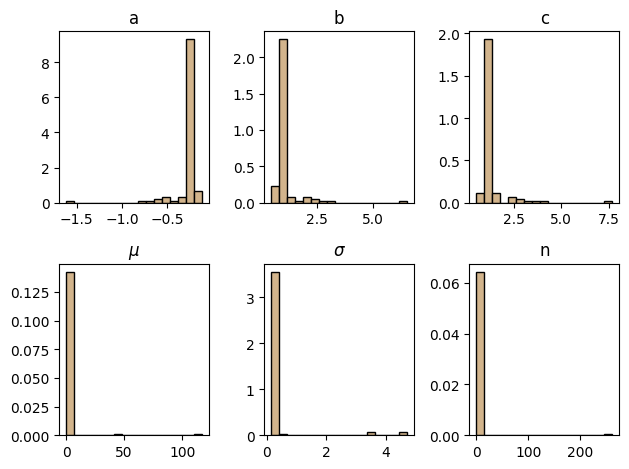

In [205]:
def hist_style(N):
    return {'bins':sturges(N),'edgecolor':'black','color':'tan'}

fig, ax = plt.subplots(nrows=2,ncols=3)
ax[0][0].hist(a,**hist_style(100),density=True)
ax[0][0].set_title('a')
ax[0][1].hist(b,**hist_style(100),density=True)
ax[0][1].set_title('b')
ax[0][2].hist(c,**hist_style(100),density=True)
ax[0][2].set_title('c')
ax[1][0].hist(m,**hist_style(100),density=True)
ax[1][0].set_title('$\mu$')
ax[1][1].hist(s,**hist_style(100),density=True)
ax[1][1].set_title('$\sigma$')
ax[1][2].hist(n,**hist_style(100),density=True)
ax[1][2].set_title('n')

plt.tight_layout()
plt.show()